# <center>Exploration<center>

<hr style="border:2px solid white"> </hr>

*$\Longrightarrow$ Ce script a été réalisé afin de créer de construire un modèle qui permet de prédire si une personne (selon ses caractéristiques) gagnera plus de 2 000 € ou non.*

In [28]:
# Chargement des bibliothèques

import pandas as pd
import numpy as np 
from sklearn.impute import KNNImputer
from sklearn.base import clone
import scipy
import sklearn
from scipy.stats import chi2_contingency
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
arr = np.array([True, False], dtype=bool)
import sys
sys.path.append('..')
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import check_X_y
#from foodcast.domain.traitement import supprimer_valeurs_aberrantes 
# --> (voir si faire mettre les fonctions de traitement.py sur ce Notebook)

In [29]:
# Récupération du fichier et des données nécessaire à l'aide ce la fonction etl

def extract(chemin_data, colonnes_a_retirer):
    
    """
        Fonction qui récupère le fichier à traiter et retire les colonnes qui ne sont pas nécessaire pour l'étude 
        et retourne la base de données avec les colonnes supprimées.
        
        :param chemin_data: (str) Le chemin permettant d'accéder au fichier.
        
        :param colonnes_a_retirer: (list) Une liste des noms des colonnes à supprimer.
        
        :return: (pandas.core.frame.DataFrame) le Data sans les colonnes à retirer (qui ont été données en paramètres)
    """
    
    # Vérification - le chemin donné en paramètres existe
    
    if os.path.exists(chemin_data) == True:
        df = pd.read_csv(chemin_data)
        
        # Vérification - les colonnes données en paramètres existent
     
        verif_colonnes_presentes =  all(colonne in df.columns for colonne in colonnes_a_retirer)
        
        if verif_colonnes_presentes == True :
            df = df.drop(colonnes_a_retirer, axis=1)
            
            return df
     
        
    
    

In [30]:
# Chargement de la base de données

data = etl('../data/fichier.csv', ['DIPL0', 'DIPL1', 'DIPL2a', 'DIPL2b', 'DIPL2c', 'DIPL3',
       'DIPL4', 'DIPL5a', 'DIPL5b', 'DIPL6a', 'DIPL6b', 'DIPL6c', 'DIPL7'])
data

,CFA,Q1,AGE13,PHD,CA9C,CA10C,CA11,CA12,SALPRSFIN
0,2,1,25,16,5,9,6.0,5.0,3433.000000
1,2,2,24,16,3,2,4.0,4.0,3183.695312
2,2,1,21,11L,4,9,3.0,5.0,3150.328125
3,2,1,25,14L,4,2,6.0,3.0,3250.000000
4,2,1,22,16,3,9,3.0,1.0,2923.000000
...,...,...,...,...,...,...,...,...,...
5995,2,2,22,16,4,4,5.0,6.0,2753.000000
5996,2,1,24,16,3,2,2.0,3.0,2700.000000
5997,2,1,22,16,2,2,3.0,5.0,2100.000000
5998,2,1,23,16,5,4,3.0,4.0,2825.000000


In [31]:
#Procède  à tous les traitements de feature ingineering pour la base de données
def redocadge (data: pd.DataFrame) :
    """
    fonction qui fait toutes les transformations de features  ingineering
    
    Parameters:
    - data (DataFrame): Le DataFrame contenant les données.

    Returns:
    - DataFrame: Le DataFrame avec les colonnes transformées 
    
    """
    
    #
    data['SALAIRE'] = data['SALPRSFIN'].apply(lambda x: 1 if x > 2000 else 0)
    data=data.drop('SALPRSFIN',axis = 1)
    
    regroupement_mapping_numerique = {'02I': 1, '02T': 1,
                                  '03I': 2, '03T': 2, '04I': 2, '04T': 2, '05': 2,
                                  '06I': 3, '07I': 3, '06T': 3, '07T': 3,
                                  '09L': 4, '09M': 4, '10L': 4, '11L': 4,
                                  '12L': 4, '10M': 4, '11M': 4, '12M': 4,
                                  '13L': 5, '14L': 5, '13M': 5, '14M': 5,
                                  '15': 6, '16': 6,
                                  '17': 7, '18L': 7, '18M': 7,
                                  '01':8,
                                  '08':9,
                                  }

    # Remplacer les modalités dans la colonne 'PHD' avec les nouvelles valeurs de regroupement numériques
    data['PHD'] = data['PHD'].replace(regroupement_mapping_numerique)
    
    
    return data


In [32]:
data = redocadge (data)
data

,CFA,Q1,AGE13,PHD,CA9C,CA10C,CA11,CA12,SALAIRE
0,2,1,25,6,5,9,6.0,5.0,1
1,2,2,24,6,3,2,4.0,4.0,1
2,2,1,21,4,4,9,3.0,5.0,1
3,2,1,25,5,4,2,6.0,3.0,1
4,2,1,22,6,3,9,3.0,1.0,1
...,...,...,...,...,...,...,...,...,...
5995,2,2,22,6,4,4,5.0,6.0,1
5996,2,1,24,6,3,2,2.0,3.0,1
5997,2,1,22,6,2,2,3.0,5.0,1
5998,2,1,23,6,5,4,3.0,4.0,1


<hr style="border:1px solid"> </hr> 

## <font color = "#2D5EAF">Description des données du fichiers</font>

<hr style="border:2px solid white"> </hr>

In [42]:
# Voir le type de chacune de nos variables

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CFA        6000 non-null   int64  
 1   Q1         6000 non-null   int64  
 2   AGE13      6000 non-null   int64  
 3   PHD        6000 non-null   int64  
 4   CA9C       6000 non-null   int64  
 5   CA10C      6000 non-null   int64  
 6   CA11       5876 non-null   float64
 7   CA12       5950 non-null   float64
 8   SALPRSFIN  6000 non-null   float64
 9   SALAIRE    6000 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 468.9 KB


In [43]:
# Résumé statistiques des données

data.describe()

,CFA,Q1,AGE13,PHD,CA9C,CA10C,CA11,CA12,SALPRSFIN,SALAIRE
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,5876.000000,5950.000000,6000.000000,6000.000000
mean,1.844500,1.473833,22.880833,4.569333,3.307333,3.379500,3.385466,3.378992,1743.617463,0.238667
std,0.362411,0.499356,3.414417,2.611448,1.878599,2.317551,2.126386,1.919999,552.836059,0.426304
min,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,206.000000,0.000000
25%,2.000000,1.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1368.000000,0.000000
50%,2.000000,1.000000,23.000000,4.000000,3.000000,2.000000,3.000000,3.000000,1600.000000,0.000000
75%,2.000000,2.000000,24.000000,7.000000,4.000000,4.000000,6.000000,5.000000,2000.000000,0.000000
max,2.000000,2.000000,53.000000,9.000000,9.000000,9.000000,7.000000,7.000000,5867.000000,1.000000


<hr style="border:1px solid"> </hr> 

## <font color = "#2D5EAF">Statistiques descriptives</font>

<hr style="border:2px solid white"> </hr>

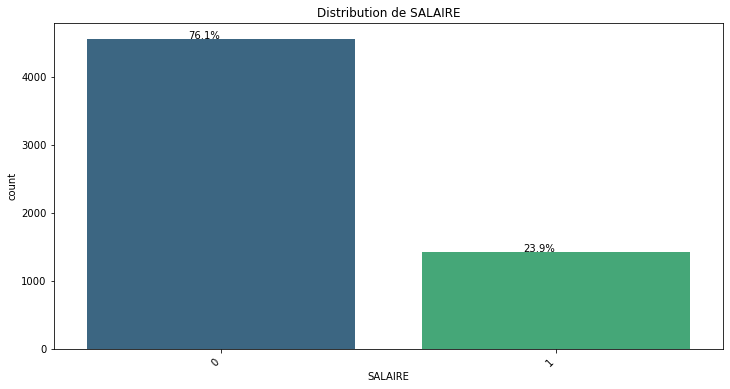

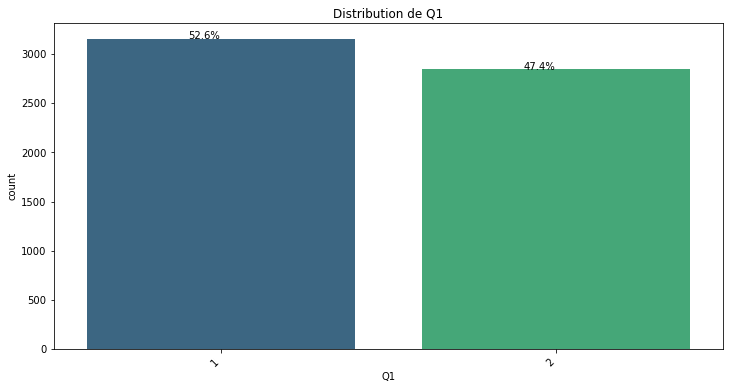

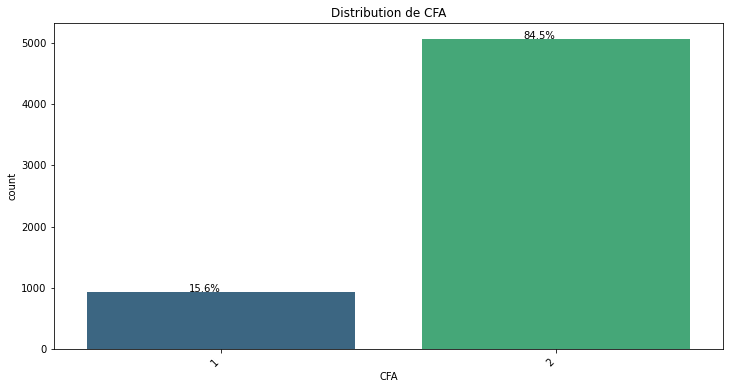

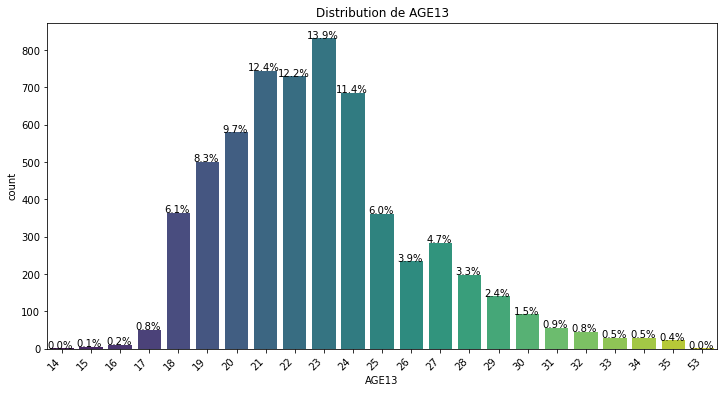

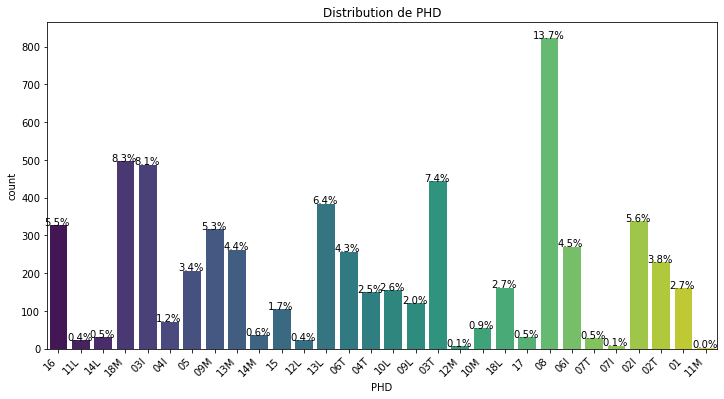

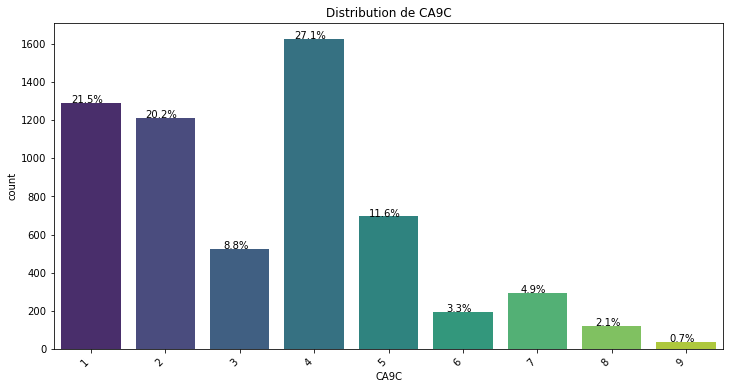

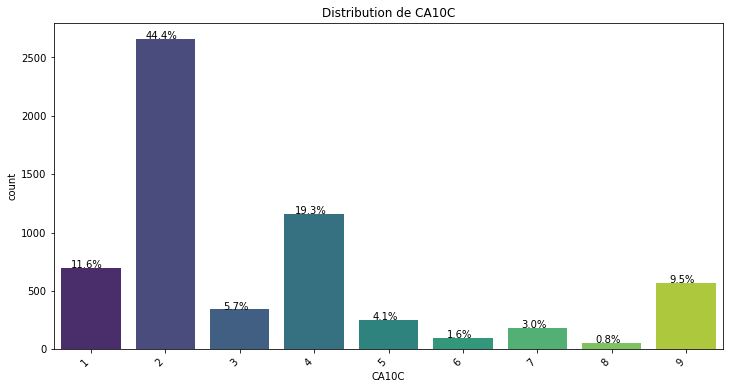

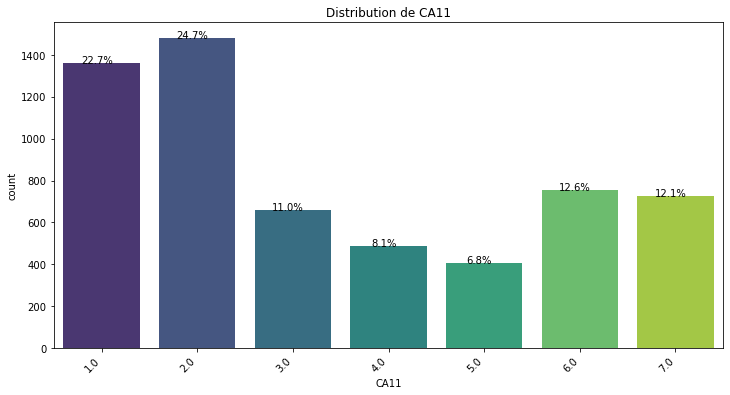

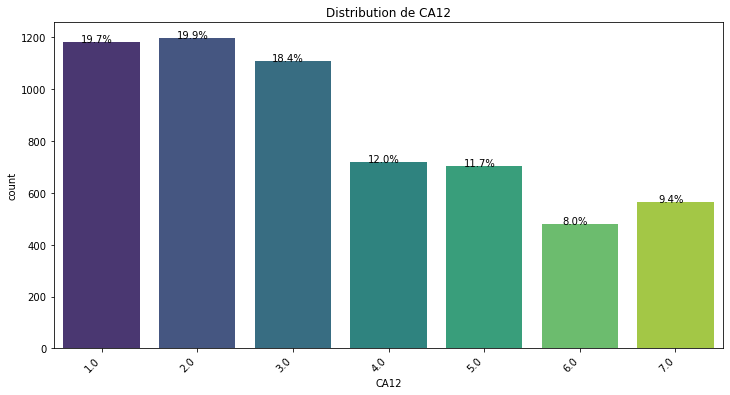

In [7]:
# Représentation graphiques de nos variables

col_categorielles = ['SALAIRE','Q1','CFA', 'AGE13', 'PHD', 'CA9C', 'CA10C', 'CA11', 'CA12']

for column in col_categorielles:
    
    # Créer le diagramme en barres avec pourcentage
    
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(x=column, data=data, palette='viridis')
    total = len(data[column])

    # Ajouter les pourcentages sur les barres
    
    for p in ax.patches:
        pct = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_height() + 0.3
        ax.annotate(pct, (x, y), ha='center', fontsize=10, color='black')

    plt.title(f'Distribution de {column}')
    plt.xticks(rotation=45, ha='right')



<hr style="border:1px solid"> </hr> 

## <font color = "#2D5EAF">Traitement des valeurs manquantes et aberrantes</font>
<hr style="border:2px solid white"> </hr>

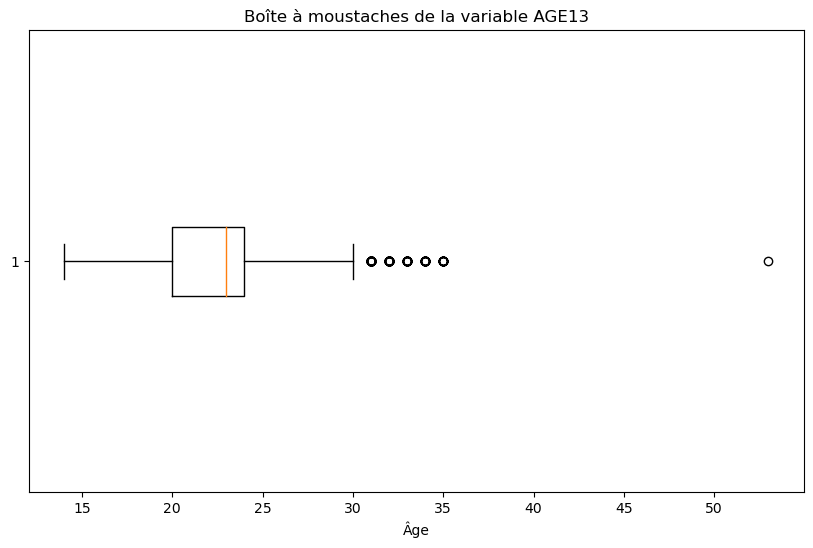

In [33]:
import matplotlib.pyplot as plt

# Créer une boîte à moustaches pour la variable AGE13
plt.figure(figsize=(10, 6))  # Ajustez la taille de la figure si nécessaire
plt.boxplot(data['AGE13'].dropna(), vert=False)  # Supprimer les valeurs manquantes

# Ajouter des étiquettes
plt.title('Boîte à moustaches de la variable AGE13')
plt.xlabel('Âge')

# Afficher le graphique
plt.show()


In [34]:
def cleaned(data: pd.DataFrame, variables: list) -> pd.DataFrame:
    """
    Supprime les valeurs aberrantes des variables spécifiées dans un DataFrame
    et remplace les valeurs manquantes en utilisant un KNNImputer.

    Parameters:
    - data (DataFrame): Le DataFrame contenant les données.
    - variables (list): La liste des noms de variables pour lesquelles supprimer les valeurs aberrantes.

    Returns:
    - DataFrame: Le DataFrame sans les valeurs aberrantes pour les variables spécifiées.
    """
    # Imputer les valeurs manquantes avec KNNImputer
    imputer = KNNImputer(n_neighbors=3)
    data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    data_imputed = data.dropna()
    # Copier le DataFrame avec les valeurs imputées pour éviter de modifier l'original
    data_cleaned = data_imputed.copy()

    for variable in variables:
        Q1 = data_cleaned[variable].quantile(0.25)
        Q3 = data_cleaned[variable].quantile(0.75)

        IQR = Q3 - Q1

        borne_inf = Q1 - 1.5 * IQR
        borne_sup = Q3 + 1.5 * IQR

        # Supprimer les valeurs aberrantes pour la variable actuelle
        data_cleaned = data_cleaned[(data_cleaned[variable] >= borne_inf) & (data_cleaned[variable] <= borne_sup)]

    # Filtrer les lignes avec des valeurs manquantes
    data_cleaned_no_missing = data_cleaned.dropna()
   
    return data_cleaned_no_missing

In [35]:
data=cleaned (data, ['AGE13'])
data.isnull().sum()

CFA        0
Q1         0
AGE13      0
PHD        0
CA9C       0
CA10C      0
CA11       0
CA12       0
SALAIRE    0
dtype: int64

In [70]:
data['CA11'].value_counts()

CA11
2.0    1480
1.0    1361
6.0     755
7.0     725
3.0     661
4.0     486
5.0     408
Name: count, dtype: int64

<hr style="border:1px solid"> </hr> 

## <font color = "#2D5EAF">Étude du lien entre les variables</font>

<hr style="border:2px solid white"> </hr>

In [36]:
def calculate_cramer_v(data: pd.DataFrame, categorical_vars: list) -> pd.DataFrame:
    """
    Calcule le V de Cramer pour chaque paire de variables catégorielles dans le DataFrame.

    Parameters:
    - data (pd.DataFrame): Le DataFrame contenant les données.
    - categorical_vars (list): La liste des noms de variables catégorielles.

    Returns:
    - pd.DataFrame: Un DataFrame contenant les valeurs du V de Cramer pour chaque paire de variables.
    """
    
    contingency_tables = {}
    for var1 in categorical_vars:
        for var2 in categorical_vars:
            contingency_table = pd.crosstab(data[var1], data[var2])
            contingency_tables[(var1, var2)] = contingency_table

    
    cramer_v_values = {}
    for (var1, var2), contingency_table in contingency_tables.items():
        chi2, _, _, _ = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim))
        cramer_v_values[(var1, var2)] = cramers_v

    
    cramer_df = pd.DataFrame(index=categorical_vars, columns=categorical_vars)
    for var1 in categorical_vars:
        for var2 in categorical_vars:
            cramer_df.loc[var1, var2] = cramer_v_values.get((var1, var2), cramer_v_values.get((var2, var1)))

    
    cramer_df = cramer_df.astype(float)

    return cramer_df


In [37]:
def plot_cramer_heatmap(cramer_df: pd.DataFrame):
    """
    Crée et affiche une heatmap du V de Cramer.

    Parameters:
    - cramer_df (pd.DataFrame): Le DataFrame contenant les valeurs du V de Cramer.
    """
    # Créez une heatmap avec seaborn
    plt.figure(figsize=(12, 8))
    sns.heatmap(cramer_df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("V de Cramer Heatmap")
    plt.show()


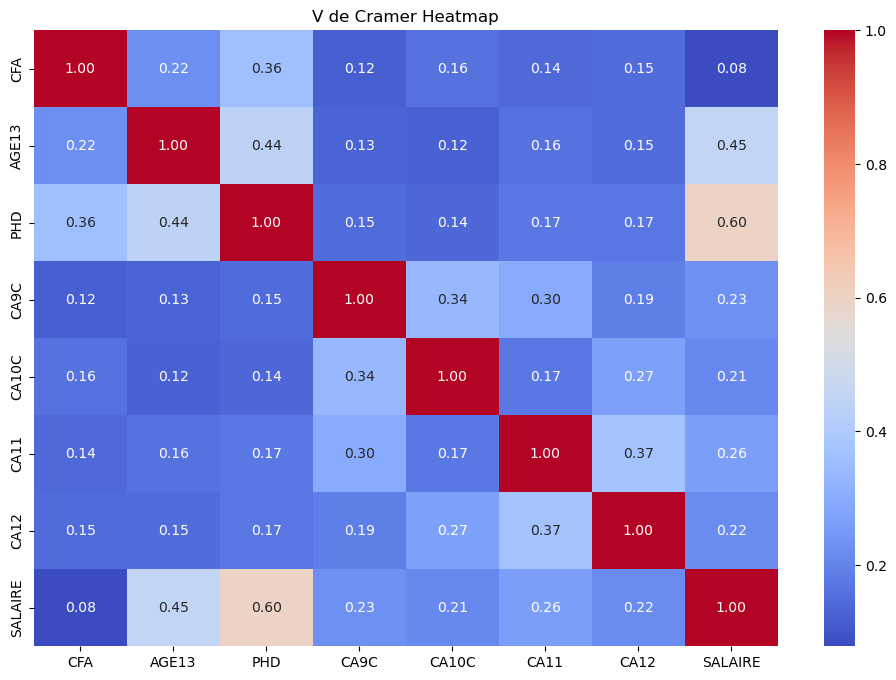

In [38]:
categorical_vars = ['CFA', 'AGE13', 'PHD', 'CA9C', 'CA10C', 'CA11', 'CA12', 'SALAIRE']
cramer_df = calculate_cramer_v(data, categorical_vars)
plot_cramer_heatmap(cramer_df)

<hr style="border:1px solid"> </hr> 

## <font color = "#2D5EAF">Modélisation</font>
<hr style="border:2px solid white"> </hr>

In [23]:
def model(data: pd.DataFrame):
    """
    Entraîne et évalue plusieurs modèles de classification sur le DataFrame d'entrée.

    Parameters:
    - data (pd.DataFrame): Le DataFrame contenant les données. Il doit inclure une colonne 'SALAIRE' comme variable cible.

    Returns:
    - pd.DataFrame: Un DataFrame contenant les résultats de l'évaluation des modèles.

    Cette fonction effectue les étapes suivantes :
    1. Divise les données d'entrée en ensembles d'entraînement et de test.
    2. Définit un ensemble de modèles de classification, y compris DecisionTree, KNeighbors, LogisticRegression et RandomForest.
    3. Spécifie des grilles d'hyperparamètres pour chaque modèle pour l'ajustement des hyperparamètres.
    4. Itère sur chaque modèle, créant un pipeline avec ou sans mise à l'échelle en fonction du type de modèle.
    5. Utilise GridSearchCV pour trouver les meilleurs hyperparamètres pour chaque modèle.
    6. Affiche et enregistre les meilleurs hyperparamètres, la précision, le score et le rapport de classification pour chaque modèle sur l'ensemble de test.

    Remarque : Cette fonction suppose que la variable cible est 'SALAIRE' dans le DataFrame d'entrée.

    Example:
    data = pd.read_csv('votre_data.csv')
    results = model(data)
    """

    y = data.SALAIRE
    X = data.drop('SALAIRE', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    models = {
        'DecisionTree': DecisionTreeClassifier(),
        'KNeighbors': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(),
        'RandomForest': RandomForestClassifier()
    }

    param_grid = {
        'DecisionTree': {'model__criterion': ['gini', 'entropy'], 'model__max_depth': [None, 5, 10, 15]},
        'KNeighbors': {'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']},
        'LogisticRegression': {'model__C': [0.1, 1, 10], 'model__penalty': ['l1', 'l2']},
        'RandomForest': {'model__n_estimators': [50, 100, 200], 'model__max_depth': [None, 5, 10, 15],
                         'model__criterion': ['gini', 'entropy']}
    }

    for model_name, model in models.items():
        if 'KNeighbors' in model_name or 'LogisticRegression' in model_name:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
        else:
            pipeline = Pipeline([
                ('model', model)
            ])

        grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        y_pred = grid_search.predict(X_test)
        print(f"Accuracy for {model_name}: {accuracy_score(y_test, y_pred)}")
        print(f"Score for {model_name}: {grid_search.score(X_test, y_test)}")
        print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}")
        print("=" * 80)


In [24]:
model (data)

Best parameters for DecisionTree: {'model__criterion': 'gini', 'model__max_depth': 5}
Accuracy for DecisionTree: 0.8492063492063492
Score for DecisionTree: 0.8492063492063492
Classification Report for DecisionTree:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       871
           1       0.73      0.56      0.63       263

    accuracy                           0.85      1134
   macro avg       0.80      0.75      0.77      1134
weighted avg       0.84      0.85      0.84      1134

Best parameters for KNeighbors: {'model__n_neighbors': 7, 'model__weights': 'uniform'}
Accuracy for KNeighbors: 0.8042328042328042
Score for KNeighbors: 0.8042328042328042
Classification Report for KNeighbors:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       871
           1       0.60      0.48      0.53       263

    accuracy                           0.80      1134
   macro avg       0.72      0

/Users/moisengouala/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/moisengouala/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/moisengouala/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moisengouala/anaconda3/lib/python3.11/site-packages/skle

Best parameters for LogisticRegression: {'model__C': 0.1, 'model__penalty': 'l2'}
Accuracy for LogisticRegression: 0.8156966490299824
Score for LogisticRegression: 0.8156966490299824
Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       871
           1       0.70      0.36      0.48       263

    accuracy                           0.82      1134
   macro avg       0.77      0.66      0.68      1134
weighted avg       0.80      0.82      0.79      1134

Best parameters for RandomForest: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__n_estimators': 100}
Accuracy for RandomForest: 0.8430335097001763
Score for RandomForest: 0.8430335097001763
Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       871
           1       0.69      0.60      0.64       263

    accuracy                     